In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "QPM_species"
model_name = "flow_spherical_mse"
ood = "1:4"

In [3]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [4]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species
Loaded 333290 images
Dataset type val label type: species
Loaded 43293 images
Dataset type test label type: species
Loaded 43520 images
Dataset type train label type: species
Loaded 42153 images
Dataset type val label type: species
Loaded 5269 images
Dataset type test label type: species
Loaded 5270 images


In [5]:
model_id = 'p965yk91'

In [6]:
model = config.get_model()

In [7]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
predict_loader = dm.predict_dataloader()

In [9]:
from models.common import edl_probs
from tqdm import tqdm

ind_targets = []
ood_targets = []

ind_u_norms = []
ood_u_norms = []
rnd_u_norms = []

ind_v_norms = []
ood_v_norms = []
rnd_v_norms = []

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
for batch_idx, batch in enumerate(tqdm(predict_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ood_u_norms.extend(u_norm.detach().cpu().numpy())
    ood_v_norms.extend(v_norm.detach().cpu().numpy())
    ood_targets.extend(y.detach().cpu().numpy())
print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

ind_targets = np.array(ind_targets).squeeze()
ood_targets = np.array(ood_targets).squeeze()
    
ind_u_norms = np.array(ind_u_norms).squeeze()
ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

ind_v_norms = np.array(ind_v_norms).squeeze()
ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(ind_u_norms.shape, ind_v_norms.shape)
print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

100%|██████████| 340/340 [00:33<00:00, 10.10it/s]


test InD - OK


100%|██████████| 412/412 [01:04<00:00,  6.43it/s]


test OoD - OK


100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


test RnD - OK
(43520,) (43520,)
(52692,) (52692,)
(12800,) (12800,)


In [10]:
ind_u_norms_scaled = np.tanh(ind_u_norms)
ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(ind_u_norms.mean(), ind_u_norms.std())
print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

0.9998633 0.00076914247
1.0000377 0.0006697954
2.5250597 0.25869453
0.0069441325 0.0018707468
0.0061674835 0.010107633
12.470295 0.32922438


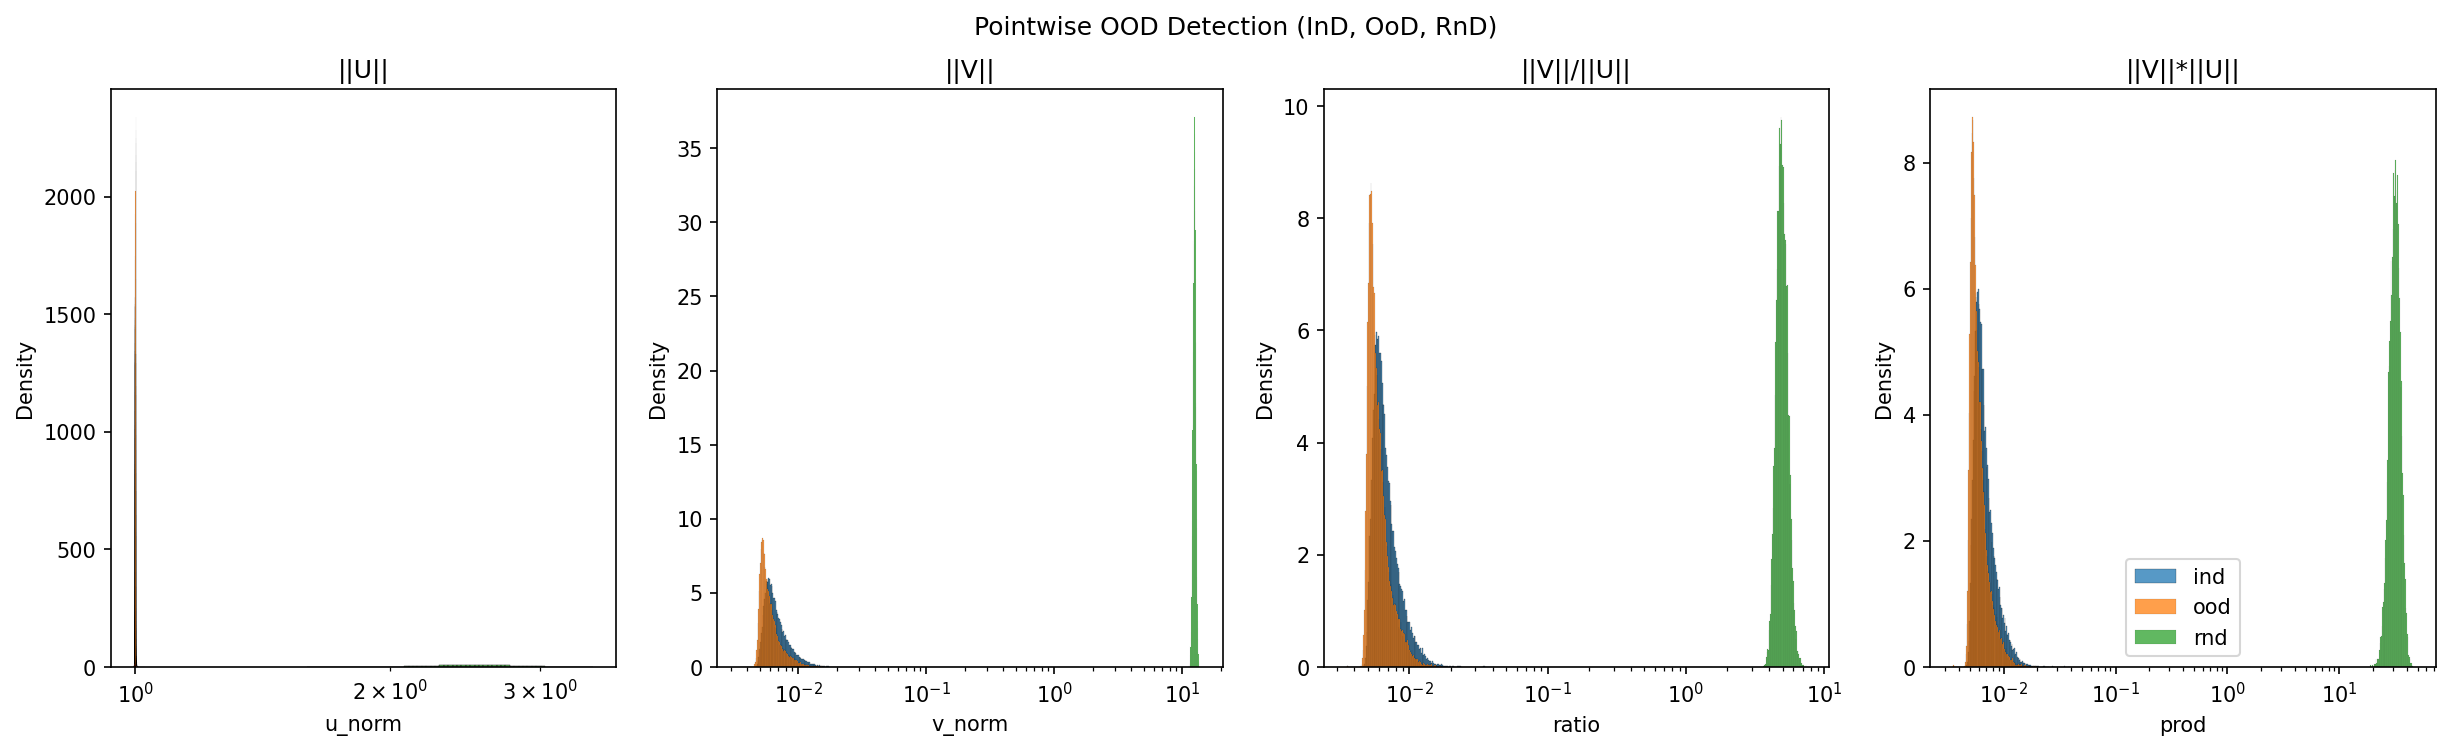

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (InD, OoD, RnD)")

sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [12]:
from scipy import stats
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
print(ks_ind_ood)

Ind 0.0035469942 0.075588204 0.07204121
Ood 0.0035469942 1.5646187 1.5610718
Rnd 11.084321 13.74345 2.6591291
KstestResult(statistic=0.30078644284376244, pvalue=0.0, statistic_location=0.0056491746, statistic_sign=-1)


[0 1 2 3 4]


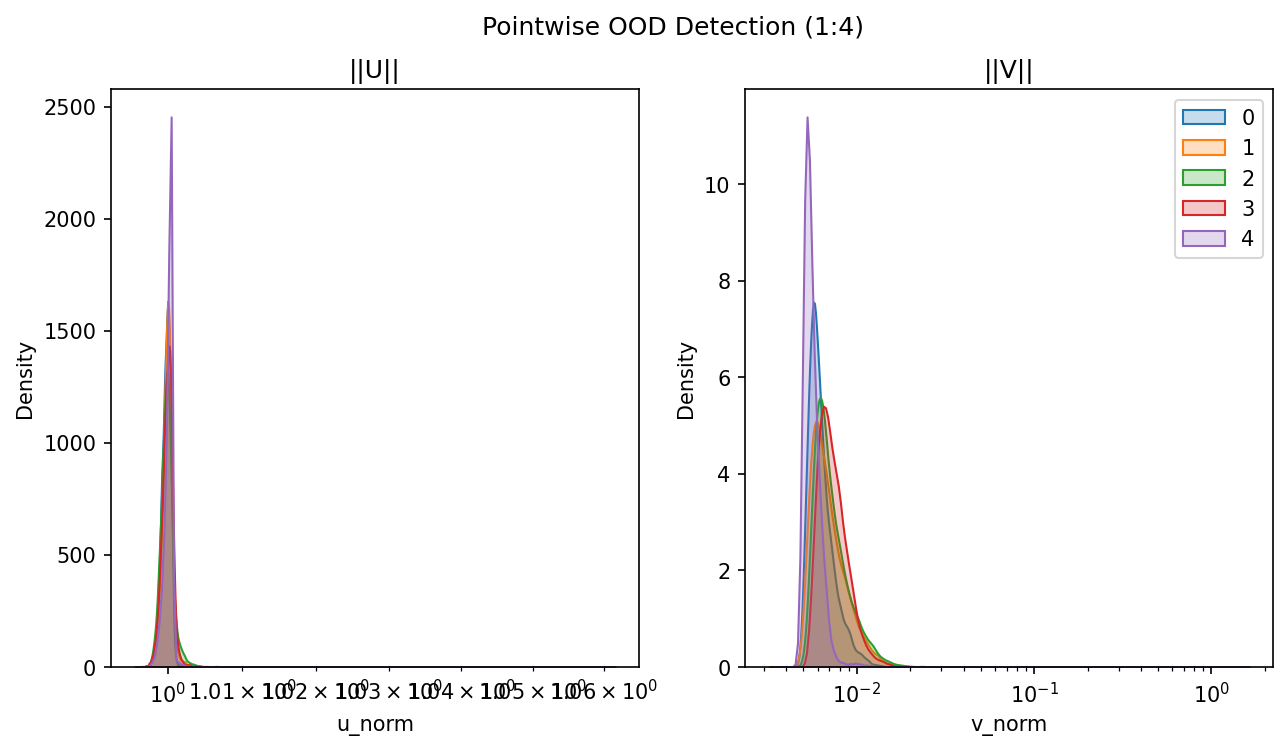

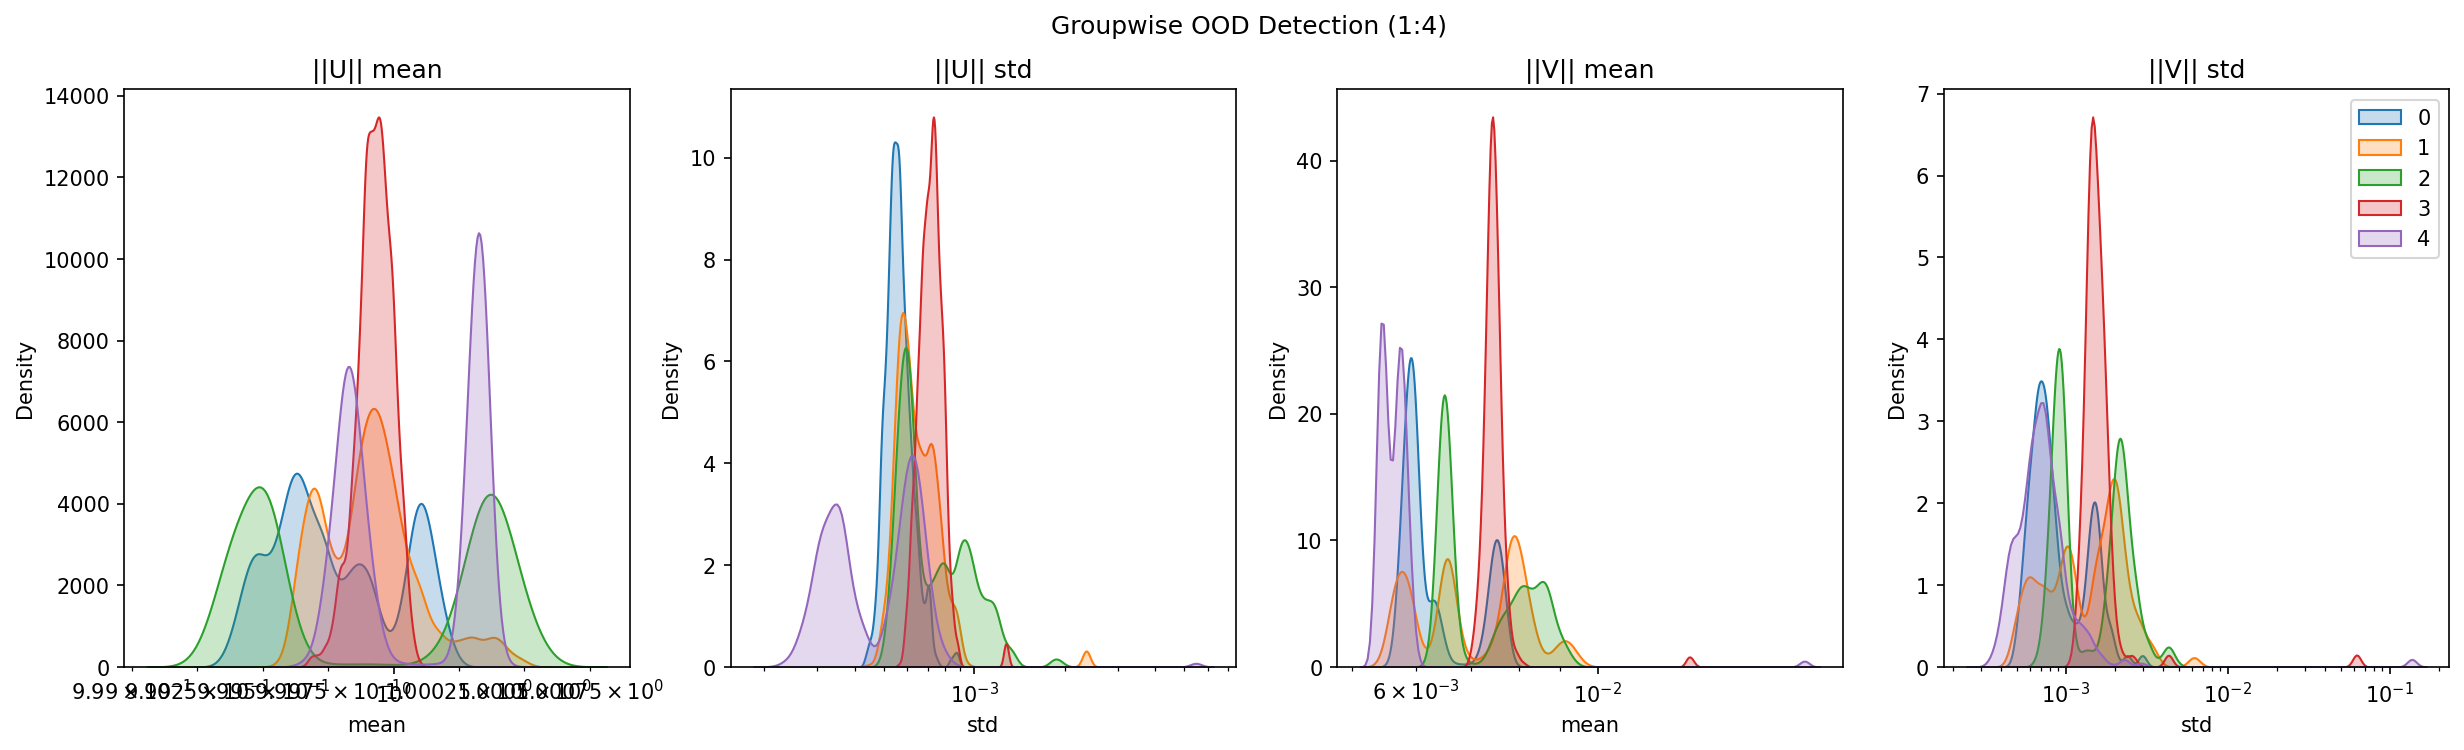

In [13]:
df = pd.concat([data_ind, data_ood], axis=0)
print(df['target'].unique())

N = 128

pointwise = {}
groupwise = {}

for i in range(5):
    df_slice = df[df['target'] == i]
    pointwise[i] = df_slice.copy()
    d = df_slice.rolling(N).agg(['mean', 'std']).dropna()
    groupwise[i] = d.copy()

# pointwise
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle(f"Pointwise OOD Detection ({':'.join(map(str,config.ood))})")

for i in range(5):
    data = pointwise[i]
    i = str(i)
    sns.kdeplot(data=data, x="u_norm", log_scale=True, fill=True, label=i, ax=ax1)
    sns.kdeplot(data=data, x="v_norm", log_scale=True, fill=True, label=i, ax=ax2)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
plt.legend()
plt.show()

    
# groupwise
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle(f"Groupwise OOD Detection ({':'.join(map(str,config.ood))})")

for i in range(5):
    data = groupwise[i]
    i = str(i)
    sns.kdeplot(data=data.u_norm, x="mean", log_scale=True, fill=True, label=i, ax=ax1)
    sns.kdeplot(data=data.u_norm, x="std", log_scale=True, fill=True, label=i, ax=ax2)
    sns.kdeplot(data=data.v_norm, x="mean", log_scale=True, fill=True, label=i, ax=ax3)
    sns.kdeplot(data=data.v_norm, x="std", log_scale=True, fill=True, label=i, ax=ax4)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()